#Paquetes necesarios

In [52]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas y algún objeto que no lo sea. Filtra los contornos que no se correpondan con monedas, y muestra el número total de monedas presentes en la imagen.

In [ ]:
umbral = 130

my_img = cv2.imread('IMG_0163.jpg') 
my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)

my_img_gris = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)

res,my_img_th1 = cv2.threshold(my_img_gris,umbral,255,cv2.THRESH_BINARY_INV)


contornos_externos, hierarchy_externos = cv2.findContours(my_img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(my_img, contornos_externos, -1, (0,255,0), 3)


count = 0
img_cont = np.zeros(my_img.shape)
for c in contornos_externos:
    area = cv2.contourArea(c)

    if area > 500:
        count += 1

        cv2.drawContours(img_cont, [c], -1, (0,0,255), -1)

        
print(f'La cantidad de monedas son: {count}')

plt.imshow(my_img) 
plt.show()
plt.imshow(img_cont) 
plt.show()

TAREA: Captura una o varias imágenes con monedas no solapadas, y otras con monedas solapadas. Identificada una moneda de un euro en la imagen, por ejemplo con un clic de ratón, calcular la cantidad de dinero presente en la imagen. ¿Qué problemas han observado?




El problema principal surgido es conseguir que cada moneda se cuente, pero que cuenta una sola vez.

Este problema es extarsobado por las monedas solapadas, las cuales obligan a reducir la distancia minima entre circulos.

Tambien existe el problema en las monedas solapadas de que circulo selecionar como la moneda de un euro.

In [ ]:
def calcular_cantidad_de_dinero_presente(img):
    cv2.destroyAllWindows()
    # Using Hugh identify all coins.
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Suaviza altas frecuencias
    pimg = cv2.medianBlur(gris, 7)
    
    circ = cv2.HoughCircles(
        pimg,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        400,  # distancia mínima entre círculos
        param1=170, # Valor del gradiente
        param2=40, #Umbral acumulador
        minRadius=300,  # radio mínimo
        maxRadius=1000,  # radio máximo
    )

    

    # Have user click on the one euro coin

    mouse_event_flag = False
    coin_value = 0
    coins = [
        (0.699354838709677, 0.01),
        (0.806451612903226, 0.02),
        (0.849462365591398, 0.1),
        (0.913978494623656, 0.05),
        (0.956989247311828, 0.2),
        (1, 1),
        (1.043010752688172, 0.5),
        (1.10752688172043, 2)
    ]
    def mouse_event(event, x, y, flags, params):
        global mouse_event_flag
        global circ
        global coin_value
        # Based on the radius of this identify all other coins and calculate total amount of cash
        
        

        if event==cv2.EVENT_LBUTTONDOWN:
            # Find coin which was clicked.
            coin_value = 0
            one_euro_radius = -1
            print('Starting circle processing.')
            for det in circ[0]:
                x_coor, y_coor, det_radio = det
                print(f'x_co {x_coor} y_cor {y_coor} x {x} y {y} rad {det_radio}')
                if (x_coor - x)**2 + (y_coor - y)**2 <= det_radio**2:
                    one_euro_radius = det_radio
                    break

            for det in circ[0]:
                x_coor, y_coor, det_radio = det
                
                ratio = det_radio / one_euro_radius

                diff = abs(ratio - coins[0][0])
                for index, coin in enumerate(coins):
                    inner_diff = abs(ratio - coin[0])

                    if inner_diff > diff:
                        print(f'index : {index} ratio: {ratio} det_radio: {det_radio} radius: {one_euro_radius}')
                        coin_value += coins[index - 1][1]
                        break
                    else:
                        diff = inner_diff


            # Set the radius of this coin as base radius.
            # Determine value of each coin based on the radius of this one coin and add to coin_value
            mouse_event_flag = True
            print(coin_value)

    img_cont = np.zeros(img.shape)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for det in circ[0]:
        x_coor, y_coor, det_radio = det
        cv2.circle(img_rgb,(int(x_coor), int(y_coor)),
            int(det_radio),(0, 255, 0), 2)
        cv2.circle(img_cont,(int(x_coor), int(y_coor)),
            int(det_radio),(255, 255, 255), -1)

    cv2.imshow('Elije una moneda de un euro', img_rgb)
    cv2.setMouseCallback('Elije una moneda de un euro', mouse_event)

    while (cv2.waitKey(20) != 27):
        pass

    return coin_value
    


img_solapada = cv2.imread('IMG_0165.jpg') 
img_no_solapada = cv2.imread('IMG_0163.jpg') 

print(calcular_cantidad_de_dinero_presente(img_solapada))
print(calcular_cantidad_de_dinero_presente(img_no_solapada))

cv2.destroyAllWindows()

Clasificación de microplásticos

TAREA: Estas tres imágenes han sido extraidas de las imágenes de mayor tamaño contenidas en la carpeta. Determina patrones geométricos para cada una de las tres clases y evalúa los aciertos y fallos con las imágenes completas la matriz de confusión. Para cada clase, determina el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifica incorrectamente por cada una de las otras dos clases.

El el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas en dicho trabajo fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación del cuadrado del perímetro con el área)
- Relación del área con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

A ojo humano se aprecia que los fragmentos suelen tener un colo claro. Los pellets varían en color pero tienen una forma geométrica mas redondo y el alquitrán se caracteriza por su color oscuro.

In [ ]:
img = cv2.imread('FRA.png') 
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

umbral = 130

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

res,img_th1 = cv2.threshold(img_gray,umbral,255,cv2.THRESH_BINARY_INV)

x = cv2.Sobel(img_th1, cv2.CV_64F, 1, 0)  # x
y = cv2.Sobel(img_th1, cv2.CV_64F, 0, 1)  # y
_, x = cv2.threshold(x, 240, 255, cv2.THRESH_BINARY)
_, y = cv2.threshold(y, 240, 255, cv2.THRESH_BINARY)

result = np.clip(np.add(x, y), 0, 255)
result = result.astype(np.uint8)

plt.imshow(result) 
plt.show()

contours, _ = cv2.findContours(result, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_filtered = []
for contour in contours:
    epsilon = 0.02*cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    area = cv2.contourArea(approx)
    if area <= 100:
        continue

    contours_filtered.append(approx)

cv2.drawContours(img_rgb, contours_filtered, -1, (0,255,0), 3)

plt.imshow(img_rgb) 
plt.show()

En el intento con Canny hay dificultad en conseguir que trabaje bien con la sombra en la parte de abajo de la imagen.

El gausian blur hace que el filtro por area no sea tan efectiva haciendo que tengamos bastante ruido en el cambio al sombreado. Aumentar el umbral nos filtra los fragmentos. Reducir el kernel gausiano funciona para quitar mas de los trozos pequeños pero también nos quita algún fragmento.

In [ ]:

def detect_contour(img, kernel, umbral):    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, kernel, 0)

    res,img_th1 = cv2.threshold(img_gray,umbral,255,cv2.THRESH_BINARY_INV)

    result = cv2.Canny(img_th1, 100, 200)
    #result = cv2.threshold(result, umbral, 255,cv2.THRESH_BINARY_INV)


    plt.imshow(result) 
    plt.show()

    contours, _ = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contours_filtered = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area <= 150:
            continue

        contours_filtered.append(contour)

    cv2.drawContours(img_rgb, contours_filtered, -1, (0,255,0), 3)

    plt.imshow(img_rgb) 
    plt.show()

    return contours_filtered

contours_FRA = detect_contour(cv2.imread('FRA.png'), (15, 15), 130)
contours_PEL = detect_contour(cv2.imread('PEL.png'), (19, 19), 110)
contours_TAR = detect_contour(cv2.imread('TAR.png'), (11, 11), 100)
contours_fragments = detect_contour(cv2.imread('fragment-03-olympus-10-01-2020.jpg'), (15, 15), 125)
contours_pellets = detect_contour(cv2.imread('pellet-03-olympus-10-01-2020.jpg'), (15, 15), 110)
contours_tar = detect_contour(cv2.imread('tar-03-olympus-10-01-2020.jpg'), (15, 15), 100)


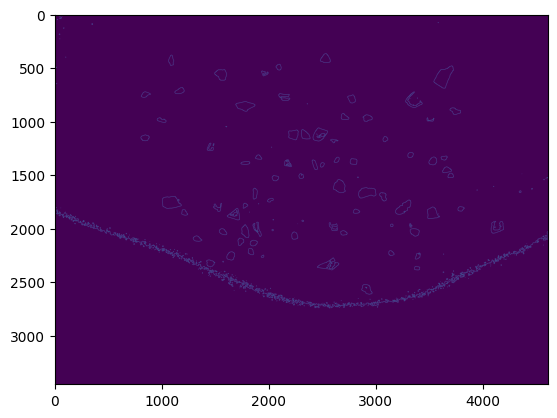

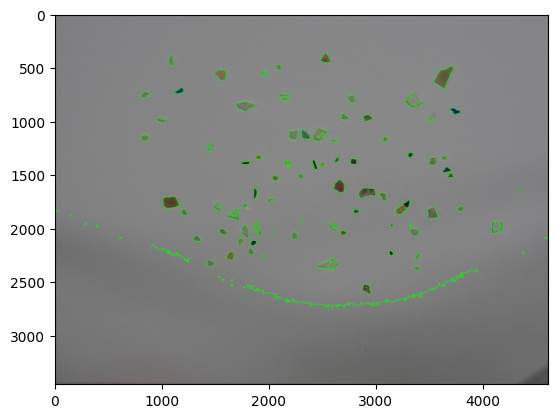

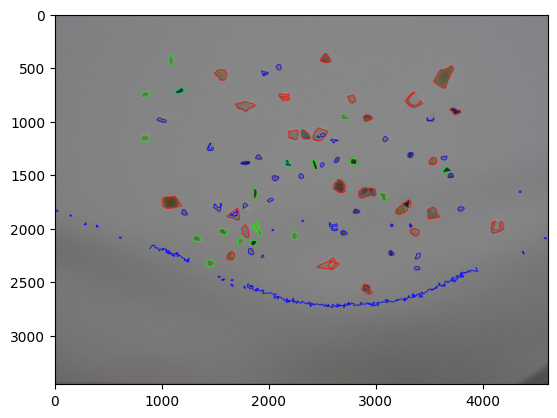

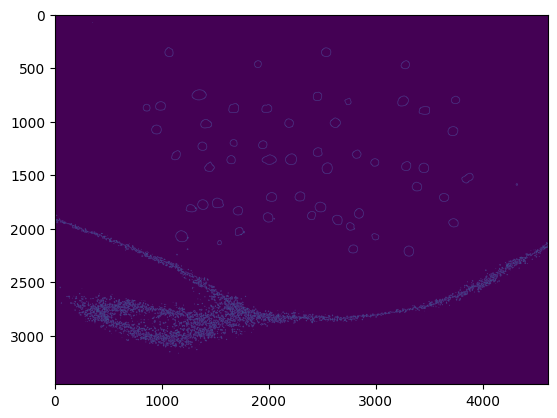

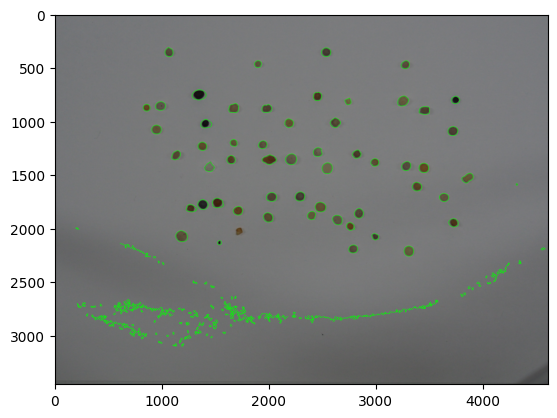

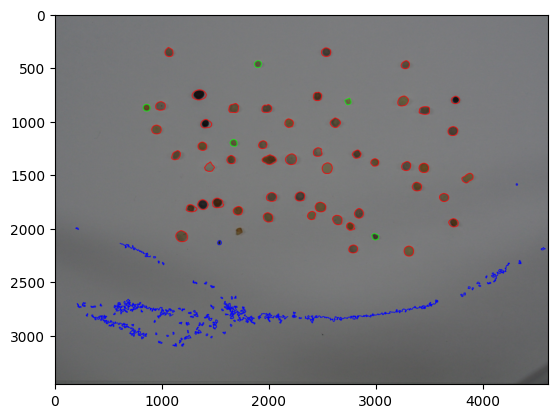

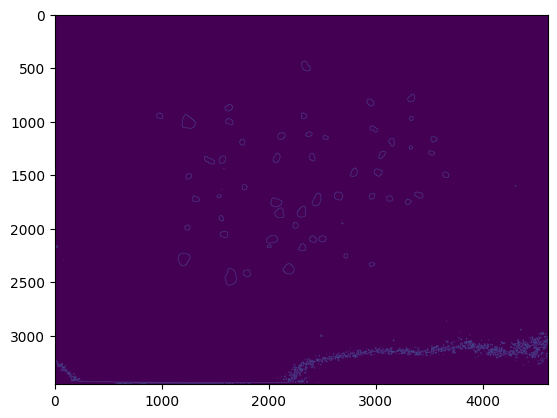

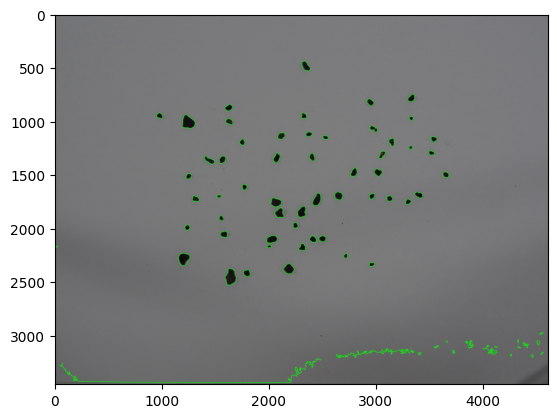

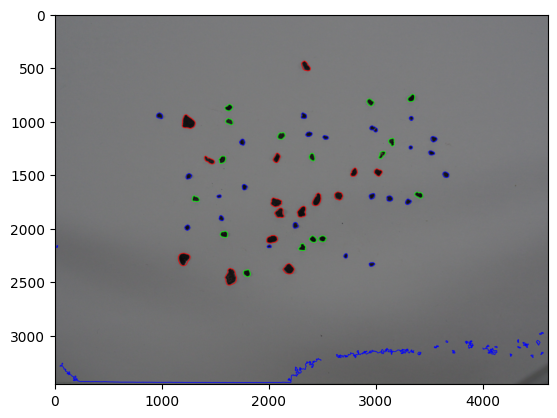

In [54]:
def process_image(img, kernel, umbral):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    contour = detect_contour(img, kernel, umbral)

    # Classification classes
    fragment = []
    pellet = []
    tar = []

    for contour in contour:
        # Criteria to determine contrours belonging to each class
        # Color?
        # Size?
        # Length?
        # https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html

        area = cv2.contourArea(contour)

        if area < 2500:
            pellet.append(contour)
        else:
            # if color dark tar else fragment
            # Can't find a way to get averege color of contour.

            if area > 3500:
                fragment.append(contour)
            else:
                tar.append(contour)


    cv2.drawContours(img_rgb, fragment, -1, (255, 0, 0), 5)  
    cv2.drawContours(img_rgb, pellet, -1, (0, 0, 255), 5)  
    cv2.drawContours(img_rgb, tar, -1, (0, 255, 0), 5)
      
    plt.imshow(img_rgb)  # Convert BGR to RGB for Matplotlib
    plt.show()

process_image(cv2.imread('fragment-03-olympus-10-01-2020.jpg'), (15, 15), 125)
process_image(cv2.imread('pellet-03-olympus-10-01-2020.jpg'), (15, 15), 110)
process_image(cv2.imread('tar-03-olympus-10-01-2020.jpg'), (15, 15), 100)

Las métricas se utilizan para mostrar la bondad de un clasificador, la siguiente celda obtiene varias para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador par alas distintas clases consideradas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente